In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [4]:
## Load Data

In [5]:
#df = pd.read_csv("airline-passengers.csv")

## Fit data

In [6]:
#df['year'] = np.array(df['Month'].apply(lambda x: x.split('-')[0]))
#df['month'] = np.array(df['Month'].apply(lambda x: x.split('-')[1]))

In [7]:
#df

In [8]:
#plt.plot(df['Passengers'].astype(float))
#plt.show()

In [9]:
## Make fake data

In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to generate a growing sine wave with increasing noise
def generate_extended_sine_wave(N, num_points_per_cycle=1000):
    # Generate time for each cycle, repeating the sine wave N times
    t = torch.linspace(0, 2 * np.pi, num_points_per_cycle)  # One cycle of sine wave
    t_extended = torch.cat([t + 2 * np.pi * i for i in range(N)])  # Extend time for N cycles

    # Generate the growing sine wave with increasing amplitude
    A = 1 + 0.1 * t_extended  # Linear growth factor
    signal = A * torch.sin(t_extended)

    # Generate increasing noise
    noise_std = 0.1 + 0.05 * t_extended  # Noise standard deviation grows over time
    noise = torch.normal(mean=torch.zeros_like(t_extended), std=noise_std)

    # Combine signal and noise
    data = signal + noise
    return t_extended, data, signal

# Parameters
N_train = 5
N_test = 3
N = N_train + N_test  # Number of cycles to repeat the sine wave
num_points_per_cycle = 5000  # Number of points per cycle

# Generate the extended sine wave data
t_extended, data, signal = generate_extended_sine_wave(N, num_points_per_cycle)

x_train = t_extended[:N_train * num_points_per_cycle].float().view(-1, 1)
y_train = data[:N_train * num_points_per_cycle].float().view(-1, 1)
x_test = t_extended[N_train * num_points_per_cycle:].float().view(-1, 1)
y_test = data[N_train * num_points_per_cycle:].float().view(-1, 1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([25000, 1]) torch.Size([25000, 1])
torch.Size([15000, 1]) torch.Size([15000, 1])


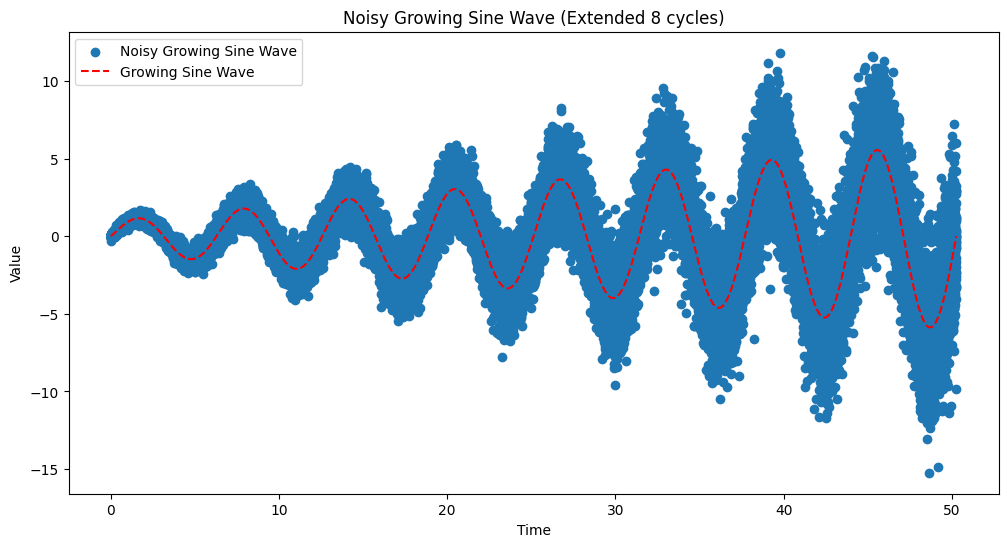

In [110]:
if True:
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.scatter(t_extended.numpy(), data.numpy(), label="Noisy Growing Sine Wave")
    plt.plot(t_extended.numpy(), signal.numpy(), label="Growing Sine Wave", linestyle='--', color='red')
    plt.legend()
    plt.title(f"Noisy Growing Sine Wave (Extended {N} cycles)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [94]:
t_extended = t_extended.reshape(-1,1)
data = data.reshape(-1,1)

x_tensor = t_extended.float().view(-1, 1)
y_tensor = data.float().view(-1, 1)

In [95]:
x_tensor.shape, y_tensor.shape

(torch.Size([40000, 1]), torch.Size([40000, 1]))

## Concept
`f(x) ~ p1 * (x / m) + (p2 * x % m)`

where x is the datatime index (can also be timestamp_i - timestamp_epoch)

In [154]:

from torch.autograd import Variable
import torch
import torch.optim as optim

    
class SinCurveFitter(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 1)
  
    def forward(self, x, return_hidden=False):
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        hidden = torch.relu(self.hidden3(x))
        x = self.output(hidden)
        if return_hidden:
            return x, hidden
        return x
    
class SimpleScaler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.layer_1 = nn.Linear(1,hidden_size)
        self.layer_2 = nn.Linear(hidden_size,1)

    def forward(self, x):
        xx = torch.relu(self.layer_1(x))
        return self.layer_2(xx)

class CycleOptimizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.sub_model = SinCurveFitter()
        self.alpha = SimpleScaler(5)
        self.beta = SimpleScaler(5)
        # take log here so we can take exp later to ensure value stays postive
        self.period_param = nn.Parameter(torch.tensor([math.log(2 * math.pi)])) 
        
    def forward(self, x):
        period = torch.exp(self.period_param)
        cycle_x = self.sub_model(x % period)
        return self.alpha(x) * cycle_x # + self.beta(x)
    
class CycleOptimizerQuantile(CycleOptimizer):
    def __init__(self):
        super().__init__()

        # for estimating variance
        self.var_hidden_1 = SimpleScaler(16)

    def forward(self, x):
        period = torch.exp(self.period_param)
        cycle_x = self.sub_model(x % period)
        var = self.var_hidden_1(x)
        return self.alpha(x) * cycle_x + self.beta(x), var



In [155]:
model = SinCurveFitter().to('cpu')
model = CycleOptimizer() # CycleOptimizerQuantile
print(model)


optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00)

CycleOptimizer(
  (sub_model): SinCurveFitter(
    (hidden): Linear(in_features=1, out_features=128, bias=True)
    (hidden2): Linear(in_features=128, out_features=256, bias=True)
    (hidden3): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=1, bias=True)
  )
  (alpha): SimpleScaler(
    (layer_1): Linear(in_features=1, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=1, bias=True)
  )
  (beta): SimpleScaler(
    (layer_1): Linear(in_features=1, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [156]:

def train_model(model, optimizer, x_train, y_train, num_epochs=1000, loss_func=nn.MSELoss):
    # Loss function (MSE)
    criterion = loss_func() #nn.MSELoss()

    for epoch in range(num_epochs):
        #model.train()

        # Forward pass: get model predictions
        predictions = model(x_train)
        
        # Compute the loss
        loss = criterion(predictions, y_train)

        # Backward pass: compute gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(model, optimizer, x_train, y_train, num_epochs=100)


Epoch [100/100], Loss: 1.0009


In [157]:
with torch.no_grad():
    y_train_pred = model(x_train)
    y_pred = model(x_test)
    y_pred_trend = model.alpha(x_test)

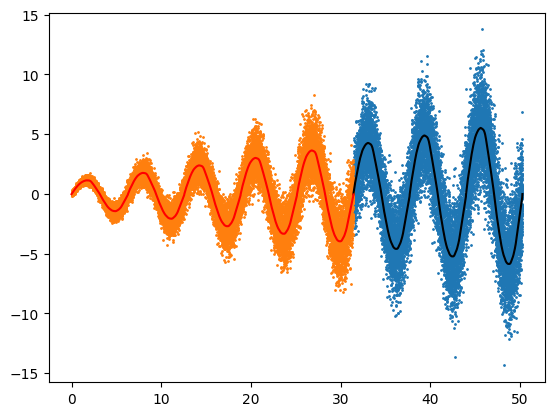

In [158]:

plt.scatter(x_test, y_test, s=1)
plt.scatter(x_train, y_train, s=1)
#plt.plot(t_extended, signal, color='green')
plt.plot(x_test, y_pred, color='black')
plt.plot(x_train, y_train_pred, color='red')
plt.plot()
plt.show()

## Fit model with variance

In [162]:

model = CycleOptimizerQuantile()
print(model)


optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00)

CycleOptimizerQuantile(
  (sub_model): SinCurveFitter(
    (hidden): Linear(in_features=1, out_features=128, bias=True)
    (hidden2): Linear(in_features=128, out_features=256, bias=True)
    (hidden3): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=1, bias=True)
  )
  (alpha): SimpleScaler(
    (layer_1): Linear(in_features=1, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=1, bias=True)
  )
  (beta): SimpleScaler(
    (layer_1): Linear(in_features=1, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=1, bias=True)
  )
  (var_hidden_1): SimpleScaler(
    (layer_1): Linear(in_features=1, out_features=16, bias=True)
    (layer_2): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [198]:

# Negative log liklihood loss
def nll_loss(y_pred, y_true):
    mu, var = y_pred  # Extract mean and variance
    loss = 0.5 * torch.mean((y_true - mu) ** 2 / var + torch.log(var))
    return loss




In [199]:
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = nll_loss(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.2057
Epoch 100: Loss = 0.1995
Epoch 200: Loss = 0.2029
Epoch 300: Loss = 0.1996
Epoch 400: Loss = 0.1965
Epoch 500: Loss = 0.1964
Epoch 600: Loss = 0.1962
Epoch 700: Loss = 0.1959
Epoch 800: Loss = 0.1960
Epoch 900: Loss = 0.2000


In [200]:

# Get model predictions
with torch.no_grad():
    mu_train, var_train = model(x_train)  # Get mean and variance predictions
    mu_test, var_test = model(x_test)  # Get mean and variance predictions
    std_train = torch.sqrt(var_train)  # Standard deviation
    std_test = torch.sqrt(var_test)  # Standard deviation

In [213]:
import scipy

dist_train = scipy.stats.norm(mu_train, scale=std_train).ppf(([0.1, 0.5, 0.9]))
dist_test  = scipy.stats.norm(mu_test, scale=std_test).ppf(np.array([0.1, 0.5, 0.9]))
print(dist_train.shape, dist_test.shape)
dist_vals = np.concat([dist_train, dist_test], axis=0)
y_low, y_mean, y_high = dist_vals[:,0], dist_vals[:,1], dist_vals[:,2]

(25000, 3) (15000, 3)


In [214]:
X = np.concat([x_train, x_test], axis=0)
X.shape

(40000, 1)

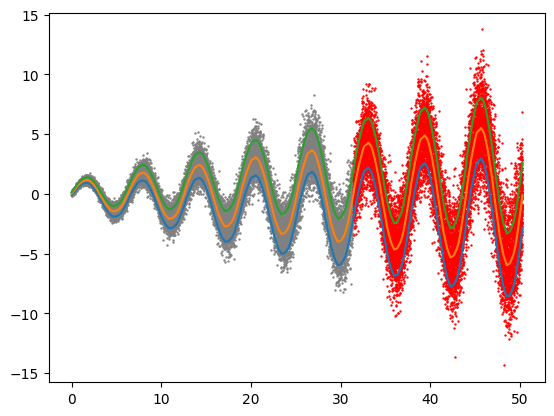

In [217]:
plt.scatter(x_train, y_train, s=0.5, color='grey')
plt.scatter(x_test, y_test, s=0.5, color='red')
plt.plot(X, y_low)
plt.plot(X, y_mean)
plt.plot(X, y_high)
